# Framework de Detecção de Deriva para Machine Learning

Este notebook implementa um framework para detecção e adaptação a mudanças conceituais (concept drift) em fluxos de dados.

## Estrutura do Framework

1. **Inicialização**: Treina um modelo inicial e configura o detector de deriva
2. **Processamento de Fluxo**: Para cada exemplo no fluxo:
   - Faz a predição com o modelo atual
   - Avalia o erro e atualiza o detector
   - Baseado no estado do detector (NORMAL, ALERTA, MUDANÇA):
     - Normal: Apenas coleta dados
     - Alerta: Adaptação incremental do modelo
     - Mudança: Reavaliação completa (usa pool de modelos ou treina um novo)

In [28]:
%pip install tqdm ipywidgets --upgrade


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import copy
from tqdm.notebook import tqdm

In [30]:
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo

In [31]:
# Modelos
modelos_offline = [
    ("LinearRegression", LinearRegressionModelo()),
    ("KNeighborsRegressor", KNeighborsRegressorModelo()),
    ("LassoRegression", LassoRegressionModelo()),
    #("MLPRegressor", MLPRegressorModelo()),  # Comentado por ser mais lento
    ("RandomForest", RandomForestModelo()),
    ("RidgeRegression", RidgeRegressionModelo()),
    ("SVR", SVRModelo())
]

## 1. Implementação do Detector de Deriva

Vamos implementar o ECDD (Error-based Concept Drift Detector) como exemplo

In [34]:
class ECDD:
    """
    Error-based Concept Drift Detector - baseado no algoritmo ECDD
    """
    def __init__(self, lambda_=0.05, warning_threshold=2.0, drift_threshold=3.0):
        self.lambda_ = lambda_  # Fator de decaimento exponencial
        self.warning_threshold = warning_threshold
        self.drift_threshold = drift_threshold

        # Inicialização de estatísticas
        self.mean = 0.0
        self.s_squared = 0.0
        self.instance_count = 0
        self.sum = 0.0
        self.squared_sum = 0.0

        # Estado atual
        self._current_state = "NORMAL"

    def update(self, error):
        """Atualiza o detector com um novo valor de erro"""
        self.instance_count += 1

        # Atualizações EWMA (Exponentially Weighted Moving Average)
        if self.instance_count == 1:
            self.mean = error
            self.s_squared = 0.0
        else:
            old_mean = self.mean
            self.mean = self.lambda_ * error + (1 - self.lambda_) * old_mean
            self.s_squared = self.lambda_ * ((error - old_mean) ** 2) + (1 - self.lambda_) * self.s_squared

        # Cálculo do desvio padronizado
        if self.instance_count < 30 or self.s_squared == 0:
            self._current_state = "NORMAL"
            return

        # Valor estatístico para detectar desvios
        deviation = abs(error - self.mean) / (self.s_squared ** 0.5)

        # Atualização do estado
        if deviation > self.drift_threshold:
            self._current_state = "MUDANÇA"
            # Reiniciar o detector após detectar mudança
            self.mean = error
            self.s_squared = 0.0
        elif deviation > self.warning_threshold:
            self._current_state = "ALERTA"
        else:
            self._current_state = "NORMAL"

    def current_state(self):
        """Retorna o estado atual do detector"""
        return self._current_state

## 2. Wrapper para Modelos

Classe para encapsular modelos de machine learning com funções para treinamento incremental e avaliação

In [36]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


class ModelWrapper:
    def __init__(self, model, incremental=False, name="Model"):
        self.model = model
        self.name = name
        self.supports_incremental = incremental
        self.predictions = []
        self.performance_history = []

    def train(self, X, y):
        """Treina o modelo com um conjunto de dados completo"""
        try:
            # Garantir que temos pelo menos duas classes para classificadores
            unique_classes = np.unique(y)
            print(f"Classes nos dados de treinamento: {unique_classes}, shape X: {X.shape}, shape y: {y.shape}")

            if len(unique_classes) < 2:
                print(f"AVISO: Tentativa de treinar com apenas {len(unique_classes)} classes. Necessário pelo menos 2.")
                return False

            print(f"Treinando modelo {type(self.model).__name__} com {len(y)} exemplos...")
            self.model.treinar(X, y)

            # Verificar se o modelo foi realmente treinado
            if hasattr(self.model, 'coef_'):
                print(f"✓ Modelo treinado com sucesso. Shape dos coeficientes: {self.model.coef_.shape}")
                return True
            else:
                print("⚠️ O modelo não parece estar treinado corretamente (sem atributo coef_).")
                return False
        except Exception as e:
            print(f"ERRO durante fit: {e}")
            import traceback
            traceback.print_exc()  # Imprime o stack trace completo para debug
            return False

    def prever(self, X):
        """Faz predição com o modelo"""
        return self.model.prever(X)

    def train_incremental(self, x, y):
        """Treina o modelo incrementalmente com um novo ponto de dados."""
        if not self.supports_incremental:
            print("Aviso: Modelo não suporta treinamento incremental.")
            return

        # Garante que x seja 2D e y seja 1D
        if x.ndim == 1:
            x = x.reshape(1, -1)
        if isinstance(y, (int, float, np.number)): # Verifica se y é escalar
             y = np.array([y]) # Converte para array 1D
        elif isinstance(y, list): # Se for lista, converte
             y = np.array(y)

        # Chama partial_fit SEM o argumento classes
        # O modelo já deve conhecer as classes do treinamento inicial (fit)
        try:
            # A maioria dos modelos que suportam partial_fit esperam as classes do fit inicial
            self.model.partial_fit(x, y)
        except AttributeError:
             # Fallback caso o modelo não tenha partial_fit (embora supports_incremental deva checar)
             print(f"Aviso: Modelo {type(self.model).__name__} não parece ter partial_fit.")
        except Exception as e:
             print(f"Erro durante partial_fit: {e}")
             # Pode ser útil inspecionar x e y aqui se o erro persistir
             # print("x shape:", x.shape)
             # print("y shape:", y.shape)
             # print("y content:", y)
             raise e # Re-levanta a exceção para não continuar com erro

    def evaluate(self, X, y):
        """
        Avalia o desempenho do modelo em um conjunto de dados usando métricas de regressão
        """
        try:
            y_pred = self.prever(X)

            # Calculando métricas de regressão
            mae = mean_absolute_error(y, y_pred)
            mse = mean_squared_error(y, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y, y_pred)

            # Normalizar R² para [0,1] como substituto para accuracy
            # R² pode ser negativo para modelos ruins, então mapeamos para [0,1]
            r2_norm = max(0.0, min(1.0, (r2 + 1) / 2))

            return {
                "mae": mae,              # Erro médio absoluto
                "mse": mse,              # Erro quadrático médio
                "rmse": rmse,            # Raiz do erro quadrático médio
                "r2": r2,                # Coeficiente de determinação
                "accuracy": r2_norm      # Para compatibilidade com o restante do código
            }
        except Exception as e:
            print(f"Erro ao calcular métricas de regressão: {e}")
            return {
                "mae": float('inf'),
                "mse": float('inf'),
                "rmse": float('inf'),
                "r2": -1.0,
                "accuracy": 0.0
            }

## 3. Funções Auxiliares para o Framework

In [37]:
def calculate_error(y_true, y_pred):
    """Calcula o erro entre a predição e o valor real"""
    return 1.0 if y_pred != y_true else 0.0

def add_to_window(window, item, max_size=200):
    """Adiciona um item à janela e mantém seu tamanho limitado"""
    window.append(item)
    if len(window) > max_size:
        window.pop(0)
    return window

def select_best_model(model_pool, recent_data_window):
    """Seleciona o melhor modelo do pool com base no desempenho na janela recente"""
    if not recent_data_window:
        return model_pool[-1]  # Retorna o modelo mais recente se não houver dados

    # Prepara os dados para avaliação
    X_window = np.array([item[0] for item in recent_data_window])
    y_window = np.array([item[1] for item in recent_data_window])

    best_model = None
    best_performance = -1

    # Avalia cada modelo
    for model in model_pool:
        performance = model.evaluate(X_window, y_window)
        if performance['accuracy'] > best_performance:
            best_performance = performance['accuracy']
            best_model = model

    return best_model, best_performance

def get_batch_from_window(window):
    """Extrai features e labels da janela de dados"""
    if not window:
        return np.array([]), np.array([])

    X = np.array([item[0] for item in window])
    y = np.array([item[1] for item in window])
    return X, y

## 4. Carregamento de Dados Sintéticos para Simulação

Vamos criar dados sintéticos com mudanças de conceito para testar o framework

Dados gerados: (10000, 10) amostras com 10 características
Pontos de deriva em: [2500, 5000, 7500]


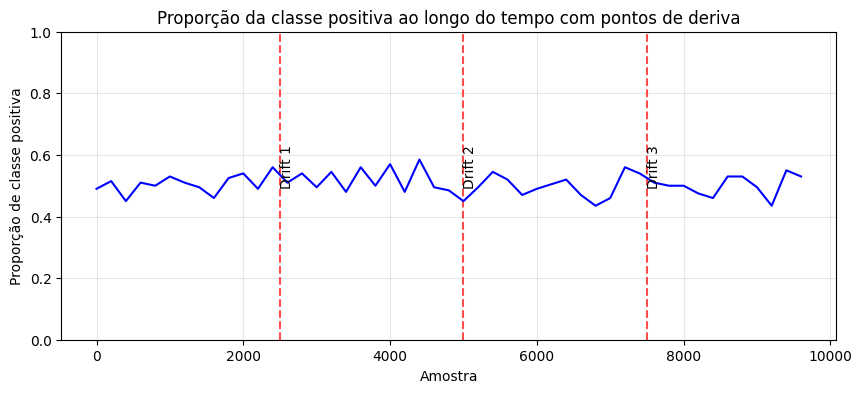

In [38]:
def generate_synthetic_data(n_samples=10000, n_features=10, n_drifts=3):
    """Gera dados sintéticos com concept drift"""
    X = np.random.randn(n_samples, n_features)
    y = np.zeros(n_samples)

    # Definir os pontos de mudança
    drift_points = [int(i * n_samples / (n_drifts + 1)) for i in range(1, n_drifts + 1)]

    # Função para criar regras diferentes para cada segmento
    def rule_1(x):# Modelos
        return 1 if x[2] - x[3] > 0 else 0
    def rule_2(x):
        return 1 if x[1] + x[6] > 0 else 0

    def rule_3(x):
        return 1 if x[0] * x[4] > 0 else 0

    def rule_4(x):
        return 1 if np.sum(x[:5]) > 0 else 0

    rules = [rule_1, rule_2, rule_3, rule_4]

    # Aplicar regras diferentes em cada segmento
    current_rule = 0
    start_idx = 0

    for drift_point in drift_points + [n_samples]:
        for i in range(start_idx, drift_point):
            y[i] = rules[current_rule](X[i])

            # Adicionar ruído (5%)
            if np.random.random() < 0.05:
                y[i] = 1 - y[i]

        start_idx = drift_point
        current_rule = (current_rule + 1) % len(rules)

    return X, y, drift_points

# Gera dados de exemplo
X, y, drift_points = generate_synthetic_data()

print(f"Dados gerados: {X.shape} amostras com {X.shape[1]} características")
print(f"Pontos de deriva em: {drift_points}")

# Visualização da distribuição das classes
plt.figure(figsize=(10, 4))
for i, dp in enumerate(drift_points):
    plt.axvline(x=dp, color='r', linestyle='--', alpha=0.7)
    plt.text(dp, 0.5, f"Drift {i+1}", rotation=90)

# Plotar a proporção de classes em janelas
window_size = 200
positions = range(0, len(y) - window_size, window_size)
proportions = [np.mean(y[i:i+window_size]) for i in positions]

plt.plot(positions, proportions, 'b-')
plt.title('Proporção da classe positiva ao longo do tempo com pontos de deriva')
plt.xlabel('Amostra')
plt.ylabel('Proporção de classe positiva')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

## 5. Implementação do Framework de Detecção de Deriva

In [39]:
def run_drift_detection_framework(X, y,model, model_name, initial_train_size=200, window_size=50, min_performance=0.6):
    """Executa o framework de detecção de deriva em um conjunto de dados"""
    # Dividir os dados em treinamento inicial e stream
    X_initial, y_initial = X[:initial_train_size], y[:initial_train_size]
    X_stream, y_stream = X[initial_train_size:], y[initial_train_size:]

    # Verificar se há classes suficientes nos dados iniciais
    unique_classes = np.unique(y_initial)
    print(f"Classes nos dados iniciais: {unique_classes}")
    if len(unique_classes) < 2:
        raise ValueError(f"Os dados iniciais precisam ter pelo menos duas classes. Classes encontradas: {unique_classes}")

    # Tentar garantir que temos amostras balanceadas das classes
    min_samples_per_class = 10  # Definir número mínimo de amostras por classe
    class_counts = {c: np.sum(y_initial == c) for c in unique_classes}
    print(f"Contagem de amostras por classe nos dados iniciais: {class_counts}")

    # Se alguma classe tiver menos amostras que o mínimo, avisar
    for c, count in class_counts.items():
        if count < min_samples_per_class:
            print(f"AVISO: Classe {c} tem apenas {count} amostras. Recomendado pelo menos {min_samples_per_class}.")

    current_model = ModelWrapper(model, incremental=hasattr(model, 'partial_fit'), name=model_name)

    # Garantir treinamento inicial correto
    print("Tentando treinar o modelo inicial...")
    train_success = current_model.train(X_initial, y_initial)

    # Teste para verificar se o modelo está realmente treinado
    try:
        test_pred = current_model.prever(X_initial[0:1])
        print("✓ Modelo inicial treinado com sucesso!")
    except Exception as e:
        raise RuntimeError(f"Modelo inicial não foi treinado corretamente: {e}")

    # Pool de modelos
    model_pool = [copy.deepcopy(current_model)]

    # Inicialização do detector
    detector = ECDD(lambda_=0.05, warning_threshold=2.0, drift_threshold=3.0)

    # Janela de dados recentes - inicialize com alguns dados do treinamento
    # Isso ajuda a ter dados de múltiplas classes disponíveis desde o início
    recent_data_window = [(X_initial[i], y_initial[i]) for i in range(max(0, len(X_initial)-10), len(X_initial))]

    # Métricas para acompanhamento
    accuracy_history = []
    error_history = []
    state_history = []
    drift_detections = []

    # Processamento do stream
    for i, (x_t, y_t) in tqdm(enumerate(zip(X_stream, y_stream)), total=len(X_stream)):
        # Garantir que x_t seja 2D para predição
        x_t_reshaped = x_t.reshape(1, -1)

        # Etapa 1: Predição
        try:
            y_pred = current_model.prever(x_t_reshaped)[0]
        except Exception as e:
            print(f"ERRO durante predição no ponto {initial_train_size + i}: {e}")
            # Usar um modelo do pool como fallback ou pular esta instância
            if len(model_pool) > 0:
                current_model = copy.deepcopy(model_pool[0])  # Use o primeiro modelo do pool como backup
                try:
                    y_pred = current_model.prever(x_t_reshaped)[0]
                except:
                    print("ERRO também no modelo de backup. Usando predição aleatória.")
                    y_pred = np.random.choice(unique_classes)  # Predição aleatória como último recurso
            else:
                y_pred = np.random.choice(unique_classes)  # Predição aleatória como último recurso

        # Etapa 2: Cálculo do erro
        error = calculate_error(y_t, y_pred)
        detector.update(error)

        # Etapa 3: Verificação do estado do detector
        state = detector._current_state  # Usar o atributo diretamente, evitando confusão com o método

        # Armazenar métricas
        error_history.append(error)
        state_history.append(state)

        if state == "NORMAL":
            # Apenas armazena os dados
            recent_data_window = add_to_window(recent_data_window, (x_t, y_t), window_size)

        elif state == "ALERTA":
            # Adapta o modelo incrementalmente
            if current_model.supports_incremental:
                current_model.train_incremental(x_t_reshaped, np.array([y_t]))
            recent_data_window = add_to_window(recent_data_window, (x_t, y_t), window_size)

        elif state == "MUDANÇA":
            # Registra o ponto de detecção de deriva
            drift_detections.append(initial_train_size + i)
            print(f"Drift detectado no ponto {initial_train_size + i}")

            # Adiciona uma cópia do modelo atual ao pool ANTES de possivelmente substituí-lo
            print(f"Adicionando modelo '{current_model.name}' ao pool (tamanho do pool: {len(model_pool)})")
            model_pool.append(copy.deepcopy(current_model))

            # Avalia modelos com base na janela recente
            X_recent, y_recent = get_batch_from_window(recent_data_window)

            if len(X_recent) > 10 and len(np.unique(y_recent)) > 1:  # Se tivermos dados suficientes e múltiplas classes
                best_model, best_performance = select_best_model(model_pool, recent_data_window)

                if best_performance >= min_performance:
                    # Não substituímos pelo mesmo modelo, apenas por outro do pool
                    if best_model.name != current_model.name:
                        current_model = copy.deepcopy(best_model)
                        print(f"Usando modelo do pool '{best_model.name}' com desempenho: {best_performance:.4f}")
                    else:
                        print(f"Mantendo modelo atual '{current_model.name}' (melhor do pool)")
                else:
                    # Treina um novo modelo com os dados recentes
                    print("Treinando novo modelo...")
                    new_model = SGDClassifier(loss='log_loss', random_state=42)
                    # Importante: dê um nome único ao novo modelo
                    new_model_name = f"New_SGD_{len(model_pool) + 1}"
                    current_model = ModelWrapper(new_model, incremental=True, name=new_model_name)
                    train_success = current_model.train(X_recent, y_recent)

                    # Se o treinamento for bem-sucedido, não precisamos adicionar aqui
                    # porque adicionaremos na próxima detecção de deriva
                    print(f"Novo modelo '{new_model_name}' treinado e definido como atual")
            else:
                # Se não tivermos dados suficientes, usamos o melhor modelo do pool
                print("Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.")
                if len(model_pool) > 1:  # Garantir que haja mais de um modelo no pool
                    # Tenta encontrar um modelo diferente do atual
                    alternative_models = [m for m in model_pool if m.name != current_model.name]
                    if alternative_models:
                        best_model = alternative_models[0]  # Escolhe um modelo alternativo como padrão

                        # Tenta encontrar o melhor modelo alternativo
                        for model in alternative_models:
                            try:
                                if len(recent_data_window) > 5:
                                    X_recent, y_recent = get_batch_from_window(recent_data_window)
                                    current_score = current_model.evaluate(X_recent, y_recent)['accuracy']
                                    model_score = model.evaluate(X_recent, y_recent)['accuracy']
                                    if model_score > current_score:
                                        best_model = model
                                        break
                            except:
                                continue

                        # Muda para o modelo alternativo
                        if best_model.name != current_model.name:
                            current_model = copy.deepcopy(best_model)
                            print(f"Usando modelo alternativo do pool: '{current_model.name}'")
                        else:
                            print(f"Mantendo modelo atual '{current_model.name}' (melhor alternativa)")
                    else:
                        print(f"Não há modelos alternativos no pool. Mantendo '{current_model.name}'")
                else:
                    print(f"Apenas um modelo no pool. Mantendo '{current_model.name}'")

            # Limpa a janela para novos dados, começando com o exemplo atual
            recent_data_window = [(x_t, y_t)]

        # Calcular a acurácia da janela
        if i % 10 == 0 and len(recent_data_window) > 1:
            X_window, y_window = get_batch_from_window(recent_data_window)
            if len(X_window) > 0:
                try:
                    window_performance = current_model.evaluate(X_window, y_window)
                    accuracy_history.append(window_performance.get('accuracy', 0))
                except Exception as e:
                    print(f"Erro ao calcular acurácia: {e}")
                    accuracy_history.append(0)  # Assumimos acurácia zero em caso de erro
            else:
                accuracy_history.append(0)

    # Resultados finais
    results = {
        "model_pool": model_pool,
        "current_model": current_model,
        "accuracy_history": accuracy_history,
        "error_history": error_history,
        "state_history": state_history,
        "drift_detections": drift_detections
    }

    return results

## 6. Executar o Framework e Visualizar Resultados

In [ ]:
# Executar o framework nos dados sintéticos
results_list = []

for name, model in modelos_offline:
    print(f"🔍 Executando experimento com modelo: {name}")
    results = run_drift_detection_framework(X, y, model_name=name, model=model)
    results['model_name'] = name
    results_list.append(results)

# Visualizar os resultados
plt.figure(figsize=(15, 10))

# Subplot 1: Visualização dos pontos de deriva verdadeiros vs. detectados
plt.subplot(3, 1, 1)
plt.title('Pontos de Deriva: Verdadeiros vs. Detectados')
for dp in drift_points:
    plt.axvline(x=dp, color='g', linestyle='--', alpha=0.7, label='Verdadeiro' if dp == drift_points[0] else '')

for dd in results['drift_detections']:
    plt.axvline(x=dd, color='r', linestyle='-', alpha=0.7, label='Detectado' if dd == results['drift_detections'][0] else '')

plt.xlabel('Amostra')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Estados do detector
plt.subplot(3, 1, 2)
plt.title('Estados do Detector ao Longo do Tempo')
states = {'NORMAL': 0, 'ALERTA': 1, 'MUDANÇA': 2}
state_values = [states[s] for s in results['state_history']]
plt.plot(range(200, 200 + len(state_values)), state_values, 'b-')
plt.yticks([0, 1, 2], ['NORMAL', 'ALERTA', 'MUDANÇA'])
plt.xlabel('Amostra')
plt.grid(True, alpha=0.3)

# Subplot 3: Acurácia ao longo do tempo
plt.subplot(3, 1, 3)
plt.title('Acurácia da Janela de Dados Recentes')
# Calculamos as posições corretas no eixo x considerando o offset inicial e a periodicidade
x_positions = [200 + i*10 for i in range(len(results['accuracy_history']))]
plt.plot(x_positions, results['accuracy_history'], 'g-')
plt.ylim(0, 1.05)
plt.xlabel('Amostra')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Informações adicionais
print(f"Número de modelos no pool: {len(results['model_pool'])}")
print(f"Pontos de deriva verdadeiros: {drift_points}")
print(f"Pontos de deriva detectados: {results['drift_detections']}")

🔍 Executando experimento com modelo: LinearRegression
Classes nos dados iniciais: [0. 1.]
Contagem de amostras por classe nos dados iniciais: {0.0: 102, 1.0: 98}
Tentando treinar o modelo inicial...
Classes nos dados de treinamento: [0. 1.], shape X: (200, 10), shape y: (200,)
Treinando modelo LinearRegressionModelo com 200 exemplos...
⚠️ O modelo não parece estar treinado corretamente (sem atributo coef_).
✓ Modelo inicial treinado com sucesso!


  0%|          | 0/9800 [00:00<?, ?it/s]

🔍 Executando experimento com modelo: KNeighborsRegressor
Classes nos dados iniciais: [0. 1.]
Contagem de amostras por classe nos dados iniciais: {0.0: 102, 1.0: 98}
Tentando treinar o modelo inicial...
Classes nos dados de treinamento: [0. 1.], shape X: (200, 10), shape y: (200,)
Treinando modelo KNeighborsRegressorModelo com 200 exemplos...
⚠️ O modelo não parece estar treinado corretamente (sem atributo coef_).
✓ Modelo inicial treinado com sucesso!


  0%|          | 0/9800 [00:00<?, ?it/s]

Drift detectado no ponto 229
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1)
Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (39, 10), shape y: (39,)
Treinando modelo SGDClassifier com 39 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_3' treinado e definido como atual
ERRO durante predição no ponto 230: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 231
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 2)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 236
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 3)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 237
Adicio

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^

Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_39' treinado e definido como atual
ERRO durante predição no ponto 417: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 417
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 38)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 420
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 39)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 422
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 40)
Dados insuficientes ou falta de

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 535
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 72)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 542
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 73)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 543
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 74)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 549
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 75)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 635
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 97)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 636
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 98)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 637
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 99)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 638
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 100)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNei

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 684
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 110)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 686
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 111)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 687
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 112)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 691
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 113)
Dados insuficientes ou falta de diversidade de classes. Usando melhor mod

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (28, 10), shape y: (28,)
Treinando modelo SGDClassifier com 28 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_133' treinado e definido como atual
ERRO durante predição no ponto 774: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 774
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 132)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 779
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 133)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 780
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 134)
Dados insuficientes ou falt

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 866
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 155)
Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_157' treinado e definido como atual
ERRO durante predição no ponto 867: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 867
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 156)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 876
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 157)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 87

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'
Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 975
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 181)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 976
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 182)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 980
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 183)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 981
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 184)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'K

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1061
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 203)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1062
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 204)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1068
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 205)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1069
Adicionando modelo 'KNeighborsRegressor' ao pool

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 1126
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 220)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1131
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 221)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1132
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 222)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1150
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 223)
Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], s

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_227' treinado e definido como atual
ERRO durante predição no ponto 1167: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1169
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 226)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1182
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 227)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 1184
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 228)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1189
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 229)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1190
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 230)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1191
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 231)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 1326
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 258)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1329
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 259)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1330
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 260)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1335
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 261)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_267' treinado e definido como atual
ERRO durante predição no ponto 1382: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1382
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 266)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1386
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 267)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1387
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 268)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_329' treinado e definido como atual
ERRO durante predição no ponto 1560: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1561
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 328)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1565
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 329)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1567
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 330)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_341' treinado e definido como atual
ERRO durante predição no ponto 1600: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1600
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 340)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1606
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 341)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1607
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 342)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 1643
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 356)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1645
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 357)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1646
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 358)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1647
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 359)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_429' treinado e definido como atual
ERRO durante predição no ponto 1915: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1915
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 428)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1924
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 429)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1925
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 430)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_441' treinado e definido como atual
ERRO durante predição no ponto 1959: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1959
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 440)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1960
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 441)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1963
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 442)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_445' treinado e definido como atual
ERRO durante predição no ponto 1978: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 1978
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 444)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1980
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 445)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 1981
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 446)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_467' treinado e definido como atual
ERRO durante predição no ponto 2028: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2028
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 466)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2059
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 467)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (31, 10), shape y: (31,)
Treinando modelo SGDClassifier com 31 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_469' treinado e definido como atual
ERRO durante predição no ponto 2060: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2060
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 468)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2061
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 469)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2062
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 470)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 2143
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 496)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2145
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 497)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2147
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 498)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2167
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 499)
Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift de

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_527' treinado e definido como atual
ERRO durante predição no ponto 2281: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2281
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 526)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2285
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 527)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2286
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 528)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_537' treinado e definido como atual
ERRO durante predição no ponto 2318: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2319
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 536)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2322
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 537)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2323
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 538)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 2367
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 550)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2371
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 551)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2372
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 552)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2373
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 553)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 2487
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 590)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2493
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 591)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2494
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 592)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2498
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 593)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_599' treinado e definido como atual
ERRO durante predição no ponto 2527: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2527
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 598)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2548
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 599)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_601' treinado e definido como atual
ERRO durante predição no ponto 2549: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2549
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 600)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2555
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 601)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2556
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 602)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (24, 10), shape y: (24,)
Treinando modelo SGDClassifier com 24 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_605' treinado e definido como atual
ERRO durante predição no ponto 2581: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2581
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 604)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2583
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 605)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2584
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 606)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_617' treinado e definido como atual
ERRO durante predição no ponto 2614: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2614
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 616)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2617
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 617)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2619
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 618)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_627' treinado e definido como atual
ERRO durante predição no ponto 2658: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2658
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 626)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2664
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 627)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2665
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 628)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_633' treinado e definido como atual
ERRO durante predição no ponto 2686: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2686
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 632)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2695
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 633)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2696
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 634)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_637' treinado e definido como atual
ERRO durante predição no ponto 2711: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2711
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 636)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2715
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 637)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2716
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 638)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_645' treinado e definido como atual
ERRO durante predição no ponto 2740: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2740
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 644)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2755
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 645)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_647' treinado e definido como atual
ERRO durante predição no ponto 2756: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2756
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 646)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2777
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 647)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_649' treinado e definido como atual
ERRO durante predição no ponto 2778: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2779
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 648)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2783
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 649)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2784
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 650)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_675' treinado e definido como atual
ERRO durante predição no ponto 2864: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2864
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 674)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2865
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 675)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2866
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 676)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_679' treinado e definido como atual
ERRO durante predição no ponto 2879: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2879
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 678)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2882
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 679)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2883
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 680)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_689' treinado e definido como atual
ERRO durante predição no ponto 2920: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2920
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 688)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2926
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 689)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2927
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 690)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_695' treinado e definido como atual
ERRO durante predição no ponto 2946: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2946
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 694)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2955
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 695)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 2956
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 696)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (34, 10), shape y: (34,)
Treinando modelo SGDClassifier com 34 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_701' treinado e definido como atual
ERRO durante predição no ponto 2994: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 2995
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 700)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3038
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 701)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (43, 10), shape y: (43,)
Treinando modelo SGDClassifier com 43 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_703' treinado e definido como atual
ERRO durante predição no ponto 3039: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3039
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 702)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3042
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 703)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3043
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 704)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_709' treinado e definido como atual
ERRO durante predição no ponto 3062: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3062
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 708)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3069
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 709)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3071
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 710)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_721' treinado e definido como atual
ERRO durante predição no ponto 3116: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3116
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 720)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3144
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 721)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (28, 10), shape y: (28,)
Treinando modelo SGDClassifier com 28 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_723' treinado e definido como atual
ERRO durante predição no ponto 3145: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3147
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 722)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3162
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 723)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_725' treinado e definido como atual
ERRO durante predição no ponto 3163: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3163
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 724)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3194
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 725)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (31, 10), shape y: (31,)
Treinando modelo SGDClassifier com 31 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_727' treinado e definido como atual
ERRO durante predição no ponto 3195: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3195
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 726)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3225
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 727)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (30, 10), shape y: (30,)
Treinando modelo SGDClassifier com 30 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_729' treinado e definido como atual
ERRO durante predição no ponto 3226: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3226
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 728)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3252
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 729)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_731' treinado e definido como atual
ERRO durante predição no ponto 3253: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3253
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 730)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3256
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 731)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3257
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 732)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (31, 10), shape y: (31,)
Treinando modelo SGDClassifier com 31 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_735' treinado e definido como atual
ERRO durante predição no ponto 3289: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3289
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 734)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3325
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 735)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (36, 10), shape y: (36,)
Treinando modelo SGDClassifier com 36 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_737' treinado e definido como atual
ERRO durante predição no ponto 3326: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3326
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 736)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3343
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 737)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_739' treinado e definido como atual
ERRO durante predição no ponto 3344: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3344
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 738)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3353
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 739)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3355
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 740)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 3395
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 748)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3398
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 749)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3401
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 750)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3402
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 751)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_765' treinado e definido como atual
ERRO durante predição no ponto 3463: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3463
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 764)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3485
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 765)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_767' treinado e definido como atual
ERRO durante predição no ponto 3486: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3486
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 766)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3507
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 767)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_769' treinado e definido como atual
ERRO durante predição no ponto 3508: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3508
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 768)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3514
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 769)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3515
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 770)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 3542
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 776)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3562
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 777)
Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_779' treinado e definido como atual
ERRO durante predição no ponto 3563: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3563
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 778)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 3586
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 782)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3590
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 783)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3592
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 784)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3597
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 785)
Dados insuficientes ou falta de diversidade de classes. Usando melhor

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_807' treinado e definido como atual
ERRO durante predição no ponto 3682: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3682
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 806)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3692
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 807)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3693
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 808)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_811' treinado e definido como atual
ERRO durante predição no ponto 3711: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3711
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 810)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3716
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 811)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3717
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 812)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (28, 10), shape y: (28,)
Treinando modelo SGDClassifier com 28 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_815' treinado e definido como atual
ERRO durante predição no ponto 3746: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3746
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 814)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3747
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 815)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3748
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 816)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_823' treinado e definido como atual
ERRO durante predição no ponto 3775: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3775
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 822)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3782
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 823)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3783
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 824)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (35, 10), shape y: (35,)
Treinando modelo SGDClassifier com 35 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_831' treinado e definido como atual
ERRO durante predição no ponto 3828: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3828
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 830)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3832
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 831)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3833
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 832)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_839' treinado e definido como atual
ERRO durante predição no ponto 3852: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3852
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 838)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3867
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 839)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_841' treinado e definido como atual
ERRO durante predição no ponto 3868: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3868
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 840)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3887
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 841)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_843' treinado e definido como atual
ERRO durante predição no ponto 3888: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3888
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 842)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3892
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 843)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3894
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 844)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_855' treinado e definido como atual
ERRO durante predição no ponto 3940: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3940
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 854)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 3981
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 855)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (41, 10), shape y: (41,)
Treinando modelo SGDClassifier com 41 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_857' treinado e definido como atual
ERRO durante predição no ponto 3982: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 3982
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 856)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4001
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 857)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_859' treinado e definido como atual
ERRO durante predição no ponto 4002: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4002
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 858)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4003
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 859)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4004
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 860)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_863' treinado e definido como atual
ERRO durante predição no ponto 4019: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4019
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 862)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4028
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 863)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4029
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 864)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_867' treinado e definido como atual
ERRO durante predição no ponto 4048: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4048
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 866)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4052
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 867)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4053
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 868)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_871' treinado e definido como atual
ERRO durante predição no ponto 4070: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4070
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 870)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4075
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 871)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4076
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 872)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (32, 10), shape y: (32,)
Treinando modelo SGDClassifier com 32 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_885' treinado e definido como atual
ERRO durante predição no ponto 4133: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4133
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 884)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4138
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 885)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4139
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 886)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (28, 10), shape y: (28,)
Treinando modelo SGDClassifier com 28 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_891' treinado e definido como atual
ERRO durante predição no ponto 4171: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4171
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 890)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4178
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 891)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4179
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 892)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (32, 10), shape y: (32,)
Treinando modelo SGDClassifier com 32 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_901' treinado e definido como atual
ERRO durante predição no ponto 4224: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4224
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 900)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4227
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 901)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4228
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 902)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_911' treinado e definido como atual
ERRO durante predição no ponto 4265: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4265
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 910)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4280
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 911)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_913' treinado e definido como atual
ERRO durante predição no ponto 4281: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4281
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 912)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4289
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 913)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4290
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 914)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_917' treinado e definido como atual
ERRO durante predição no ponto 4309: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4309
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 916)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4325
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 917)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_919' treinado e definido como atual
ERRO durante predição no ponto 4326: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4326
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 918)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4330
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 919)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4331
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 920)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_927' treinado e definido como atual
ERRO durante predição no ponto 4358: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4358
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 926)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4385
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 927)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_929' treinado e definido como atual
ERRO durante predição no ponto 4386: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4386
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 928)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4444
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 929)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_931' treinado e definido como atual
ERRO durante predição no ponto 4445: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4445
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 930)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4470
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 931)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_933' treinado e definido como atual
ERRO durante predição no ponto 4471: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4471
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 932)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4488
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 933)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_935' treinado e definido como atual
ERRO durante predição no ponto 4489: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4489
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 934)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4540
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 935)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_937' treinado e definido como atual
ERRO durante predição no ponto 4541: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4541
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 936)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4563
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 937)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_939' treinado e definido como atual
ERRO durante predição no ponto 4564: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4564
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 938)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4567
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 939)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4568
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 940)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_943' treinado e definido como atual
ERRO durante predição no ponto 4580: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4580
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 942)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4584
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 943)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4585
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 944)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_947' treinado e definido como atual
ERRO durante predição no ponto 4598: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4598
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 946)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4620
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 947)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_949' treinado e definido como atual
ERRO durante predição no ponto 4621: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4621
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 948)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4633
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 949)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_951' treinado e definido como atual
ERRO durante predição no ponto 4634: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4634
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 950)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4635
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 951)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4636
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 952)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_959' treinado e definido como atual
ERRO durante predição no ponto 4655: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4655
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 958)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4662
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 959)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4663
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 960)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_963' treinado e definido como atual
ERRO durante predição no ponto 4679: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4679
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 962)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4682
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 963)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4683
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 964)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_971' treinado e definido como atual
ERRO durante predição no ponto 4702: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4702
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 970)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4728
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 971)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_973' treinado e definido como atual
ERRO durante predição no ponto 4729: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4729
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 972)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4739
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 973)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4740
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 974)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_977' treinado e definido como atual
ERRO durante predição no ponto 4753: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4753
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 976)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4771
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 977)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_979' treinado e definido como atual
ERRO durante predição no ponto 4772: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4772
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 978)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4778
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 979)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4779
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 980)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_985' treinado e definido como atual
ERRO durante predição no ponto 4811: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4811
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 984)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4853
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 985)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (42, 10), shape y: (42,)
Treinando modelo SGDClassifier com 42 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_987' treinado e definido como atual
ERRO durante predição no ponto 4854: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4855
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 986)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4860
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 987)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4861
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 988)
Dados insuficientes ou 

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_999' treinado e definido como atual
ERRO durante predição no ponto 4912: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4912
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 998)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4913
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 999)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4914
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1000)
Dados insuficientes ou

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (24, 10), shape y: (24,)
Treinando modelo SGDClassifier com 24 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1003' treinado e definido como atual
ERRO durante predição no ponto 4939: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4940
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1002)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4973
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1003)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (33, 10), shape y: (33,)
Treinando modelo SGDClassifier com 33 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1005' treinado e definido como atual
ERRO durante predição no ponto 4974: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4974
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1004)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4987
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1005)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1007' treinado e definido como atual
ERRO durante predição no ponto 4988: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 4988
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1006)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4989
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1007)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 4990
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1008)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1013' treinado e definido como atual
ERRO durante predição no ponto 5021: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5021
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1012)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5024
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1013)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5025
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1014)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1019' treinado e definido como atual
ERRO durante predição no ponto 5051: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5051
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1018)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5055
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1019)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5056
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1020)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1033' treinado e definido como atual
ERRO durante predição no ponto 5103: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5103
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1032)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5108
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1033)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5109
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1034)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1039' treinado e definido como atual
ERRO durante predição no ponto 5129: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5130
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1038)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5150
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1039)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1041' treinado e definido como atual
ERRO durante predição no ponto 5151: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5151
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1040)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5158
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1041)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5159
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1042)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (35, 10), shape y: (35,)
Treinando modelo SGDClassifier com 35 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1045' treinado e definido como atual
ERRO durante predição no ponto 5195: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5195
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1044)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5221
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1045)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1047' treinado e definido como atual
ERRO durante predição no ponto 5222: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5222
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1046)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5223
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1047)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5225
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1048)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1055' treinado e definido como atual
ERRO durante predição no ponto 5249: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5249
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1054)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5266
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1055)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1057' treinado e definido como atual
ERRO durante predição no ponto 5267: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5267
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1056)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5279
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1057)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1059' treinado e definido como atual
ERRO durante predição no ponto 5280: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5280
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1058)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5293
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1059)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1061' treinado e definido como atual
ERRO durante predição no ponto 5294: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5294
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1060)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5311
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1061)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1063' treinado e definido como atual
ERRO durante predição no ponto 5312: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5312
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1062)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5320
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1063)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5321
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1064)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1069' treinado e definido como atual
ERRO durante predição no ponto 5351: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5351
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1068)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5376
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1069)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1071' treinado e definido como atual
ERRO durante predição no ponto 5377: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5377
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1070)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5392
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1071)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1073' treinado e definido como atual
ERRO durante predição no ponto 5393: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5393
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1072)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5395
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1073)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5396
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1074)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1077' treinado e definido como atual
ERRO durante predição no ponto 5424: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5425
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1076)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5426
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1077)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5427
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1078)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1081' treinado e definido como atual
ERRO durante predição no ponto 5449: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5449
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1080)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5455
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1081)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5457
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1082)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1087' treinado e definido como atual
ERRO durante predição no ponto 5477: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5477
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1086)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5482
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1087)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5484
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1088)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1093' treinado e definido como atual
ERRO durante predição no ponto 5504: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5504
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1092)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5526
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1093)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1095' treinado e definido como atual
ERRO durante predição no ponto 5527: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5527
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1094)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5543
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1095)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1097' treinado e definido como atual
ERRO durante predição no ponto 5544: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5544
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1096)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5558
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1097)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1099' treinado e definido como atual
ERRO durante predição no ponto 5559: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5559
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1098)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5562
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1099)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5563
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1100)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1103' treinado e definido como atual
ERRO durante predição no ponto 5585: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5585
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1102)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5589
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1103)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5590
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1104)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1107' treinado e definido como atual
ERRO durante predição no ponto 5603: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5603
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1106)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5608
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1107)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5609
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1108)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1119' treinado e definido como atual
ERRO durante predição no ponto 5647: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5648
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1118)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5653
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1119)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5654
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1120)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1125' treinado e definido como atual
ERRO durante predição no ponto 5677: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5677
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1124)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5696
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1125)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1127' treinado e definido como atual
ERRO durante predição no ponto 5697: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5697
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1126)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5701
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1127)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5702
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1128)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1135' treinado e definido como atual
ERRO durante predição no ponto 5730: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5730
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1134)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5733
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1135)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5734
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1136)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1153' treinado e definido como atual
ERRO durante predição no ponto 5796: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5796
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1152)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5799
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1153)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5800
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1154)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (40, 10), shape y: (40,)
Treinando modelo SGDClassifier com 40 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1157' treinado e definido como atual
ERRO durante predição no ponto 5841: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5841
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1156)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5854
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1157)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1159' treinado e definido como atual
ERRO durante predição no ponto 5855: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5855
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1158)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5857
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1159)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5858
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1160)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1165' treinado e definido como atual
ERRO durante predição no ponto 5880: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5880
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1164)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5884
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1165)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5885
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1166)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1171' treinado e definido como atual
ERRO durante predição no ponto 5906: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5906
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1170)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5912
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1171)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5913
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1172)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1177' treinado e definido como atual
ERRO durante predição no ponto 5940: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5940
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1176)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5947
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1177)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5948
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1178)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1187' treinado e definido como atual
ERRO durante predição no ponto 5976: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 5976
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1186)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5977
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1187)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 5978
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1188)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1191' treinado e definido como atual
ERRO durante predição no ponto 6006: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6006
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1190)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6027
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1191)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1193' treinado e definido como atual
ERRO durante predição no ponto 6028: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6028
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1192)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6035
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1193)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6036
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1194)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (47, 10), shape y: (47,)
Treinando modelo SGDClassifier com 47 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1197' treinado e definido como atual
ERRO durante predição no ponto 6084: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6085
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1196)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6090
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1197)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6092
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1198)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1211' treinado e definido como atual
ERRO durante predição no ponto 6133: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6133
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1210)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6143
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1211)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6145
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1212)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1215' treinado e definido como atual
ERRO durante predição no ponto 6168: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6168
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1214)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6171
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1215)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6172
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1216)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1219' treinado e definido como atual
ERRO durante predição no ponto 6194: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6194
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1218)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6202
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1219)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6203
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1220)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1231' treinado e definido como atual
ERRO durante predição no ponto 6242: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6242
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1230)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6244
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1231)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6245
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1232)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (47, 10), shape y: (47,)
Treinando modelo SGDClassifier com 47 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1247' treinado e definido como atual
ERRO durante predição no ponto 6322: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6322
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1246)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6332
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1247)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6333
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1248)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (31, 10), shape y: (31,)
Treinando modelo SGDClassifier com 31 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1251' treinado e definido como atual
ERRO durante predição no ponto 6365: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6365
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1250)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6378
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1251)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1253' treinado e definido como atual
ERRO durante predição no ponto 6379: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6379
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1252)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6380
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1253)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6384
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1254)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1263' treinado e definido como atual
ERRO durante predição no ponto 6426: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6426
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1262)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6446
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1263)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1265' treinado e definido como atual
ERRO durante predição no ponto 6447: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6447
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1264)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6457
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1265)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6458
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1266)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (33, 10), shape y: (33,)
Treinando modelo SGDClassifier com 33 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1271' treinado e definido como atual
ERRO durante predição no ponto 6498: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6499
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1270)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6510
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1271)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1273' treinado e definido como atual
ERRO durante predição no ponto 6511: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6511
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1272)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6514
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1273)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6516
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1274)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1277' treinado e definido como atual
ERRO durante predição no ponto 6539: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6539
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1276)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6559
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1277)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1279' treinado e definido como atual
ERRO durante predição no ponto 6560: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6560
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1278)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6588
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1279)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (28, 10), shape y: (28,)
Treinando modelo SGDClassifier com 28 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1281' treinado e definido como atual
ERRO durante predição no ponto 6589: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6589
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1280)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6591
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1281)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6593
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1282)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (23, 10), shape y: (23,)
Treinando modelo SGDClassifier com 23 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1287' treinado e definido como atual
ERRO durante predição no ponto 6621: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6621
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1286)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6622
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1287)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6623
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1288)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1299' treinado e definido como atual
ERRO durante predição no ponto 6651: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6651
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1298)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6663
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1299)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1301' treinado e definido como atual
ERRO durante predição no ponto 6664: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6664
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1300)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6703
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1301)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (39, 10), shape y: (39,)
Treinando modelo SGDClassifier com 39 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1303' treinado e definido como atual
ERRO durante predição no ponto 6704: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6704
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1302)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6731
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1303)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1305' treinado e definido como atual
ERRO durante predição no ponto 6732: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6732
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1304)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6733
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1305)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6734
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1306)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1311' treinado e definido como atual
ERRO durante predição no ponto 6751: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6751
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1310)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6756
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1311)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6758
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1312)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (29, 10), shape y: (29,)
Treinando modelo SGDClassifier com 29 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1315' treinado e definido como atual
ERRO durante predição no ponto 6788: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6788
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1314)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6797
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1315)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6798
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1316)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1327' treinado e definido como atual
ERRO durante predição no ponto 6845: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6845
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1326)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6859
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1327)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1329' treinado e definido como atual
ERRO durante predição no ponto 6860: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6860
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1328)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6864
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1329)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6865
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1330)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1343' treinado e definido como atual
ERRO durante predição no ponto 6906: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6906
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1342)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6919
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1343)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1345' treinado e definido como atual
ERRO durante predição no ponto 6920: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6920
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1344)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6925
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1345)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6926
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1346)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1357' treinado e definido como atual
ERRO durante predição no ponto 6973: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 6973
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1356)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6977
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1357)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 6978
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1358)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1361' treinado e definido como atual
ERRO durante predição no ponto 7006: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7006
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1360)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7019
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1361)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1363' treinado e definido como atual
ERRO durante predição no ponto 7020: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7020
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1362)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7031
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1363)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1365' treinado e definido como atual
ERRO durante predição no ponto 7032: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7033
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1364)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7043
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1365)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7044
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1366)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1369' treinado e definido como atual
ERRO durante predição no ponto 7062: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7062
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1368)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7071
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1369)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7072
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1370)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1373' treinado e definido como atual
ERRO durante predição no ponto 7089: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7090
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1372)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7091
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1373)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7092
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1374)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1383' treinado e definido como atual
ERRO durante predição no ponto 7125: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7125
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1382)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7144
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1383)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1385' treinado e definido como atual
ERRO durante predição no ponto 7145: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7146
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1384)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7168
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1385)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (22, 10), shape y: (22,)
Treinando modelo SGDClassifier com 22 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1387' treinado e definido como atual
ERRO durante predição no ponto 7169: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7169
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1386)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7177
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1387)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7178
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1388)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1405' treinado e definido como atual
ERRO durante predição no ponto 7239: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7239
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1404)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7257
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1405)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1407' treinado e definido como atual
ERRO durante predição no ponto 7258: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7258
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1406)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7263
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1407)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7264
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1408)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (41, 10), shape y: (41,)
Treinando modelo SGDClassifier com 41 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1415' treinado e definido como atual
ERRO durante predição no ponto 7313: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7313
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1414)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7315
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1415)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7316
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1416)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1423' treinado e definido como atual
ERRO durante predição no ponto 7334: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7334
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1422)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7350
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1423)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1425' treinado e definido como atual
ERRO durante predição no ponto 7351: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7351
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1424)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7362
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1425)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1427' treinado e definido como atual
ERRO durante predição no ponto 7363: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7363
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1426)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7364
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1427)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7365
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1428)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Mantendo modelo atual 'KNeighborsRegressor' (melhor do pool)
Drift detectado no ponto 7400
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1436)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7401
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1437)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7402
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1438)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7404
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1439)
Dados insuficientes ou falta de diversidade de classes. Usando me

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1465' treinado e definido como atual
ERRO durante predição no ponto 7516: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7516
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1464)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7521
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1465)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7523
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1466)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (18, 10), shape y: (18,)
Treinando modelo SGDClassifier com 18 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1473' treinado e definido como atual
ERRO durante predição no ponto 7553: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7553
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1472)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7612
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1473)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1475' treinado e definido como atual
ERRO durante predição no ponto 7613: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7613
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1474)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7636
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1475)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (23, 10), shape y: (23,)
Treinando modelo SGDClassifier com 23 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1477' treinado e definido como atual
ERRO durante predição no ponto 7637: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7637
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1476)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7644
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1477)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7645
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1478)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (33, 10), shape y: (33,)
Treinando modelo SGDClassifier com 33 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1483' treinado e definido como atual
ERRO durante predição no ponto 7689: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7689
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1482)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7705
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1483)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1485' treinado e definido como atual
ERRO durante predição no ponto 7706: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7706
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1484)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7709
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1485)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7710
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1486)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (40, 10), shape y: (40,)
Treinando modelo SGDClassifier com 40 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1489' treinado e definido como atual
ERRO durante predição no ponto 7751: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7752
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1488)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7754
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1489)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7755
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1490)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1493' treinado e definido como atual
ERRO durante predição no ponto 7769: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7769
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1492)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7772
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1493)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7773
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1494)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1499' treinado e definido como atual
ERRO durante predição no ponto 7804: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7804
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1498)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7818
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1499)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1501' treinado e definido como atual
ERRO durante predição no ponto 7819: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7819
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1500)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7843
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1501)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (24, 10), shape y: (24,)
Treinando modelo SGDClassifier com 24 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1503' treinado e definido como atual
ERRO durante predição no ponto 7844: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7844
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1502)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7882
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1503)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (38, 10), shape y: (38,)
Treinando modelo SGDClassifier com 38 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1505' treinado e definido como atual
ERRO durante predição no ponto 7883: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7883
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1504)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7908
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1505)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1507' treinado e definido como atual
ERRO durante predição no ponto 7909: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7909
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1506)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7921
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1507)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1509' treinado e definido como atual
ERRO durante predição no ponto 7922: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7922
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1508)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7939
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1509)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1511' treinado e definido como atual
ERRO durante predição no ponto 7940: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7941
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1510)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7945
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1511)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7946
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1512)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1515' treinado e definido como atual
ERRO durante predição no ponto 7964: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7964
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1514)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7971
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1515)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7972
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1516)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1521' treinado e definido como atual
ERRO durante predição no ponto 7992: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 7992
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1520)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7997
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1521)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 7998
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1522)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1527' treinado e definido como atual
ERRO durante predição no ponto 8057: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8057
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1526)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8070
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1527)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1529' treinado e definido como atual
ERRO durante predição no ponto 8071: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8071
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1528)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8072
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1529)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8073
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1530)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (23, 10), shape y: (23,)
Treinando modelo SGDClassifier com 23 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1535' treinado e definido como atual
ERRO durante predição no ponto 8102: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8102
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1534)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8117
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1535)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1537' treinado e definido como atual
ERRO durante predição no ponto 8118: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8118
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1536)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8126
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1537)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8127
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1538)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1545' treinado e definido como atual
ERRO durante predição no ponto 8163: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8163
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1544)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8164
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1545)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8165
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1546)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1549' treinado e definido como atual
ERRO durante predição no ponto 8180: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8181
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1548)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8208
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1549)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1551' treinado e definido como atual
ERRO durante predição no ponto 8209: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8209
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1550)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8225
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1551)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1553' treinado e definido como atual
ERRO durante predição no ponto 8226: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8226
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1552)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8247
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1553)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1555' treinado e definido como atual
ERRO durante predição no ponto 8248: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8248
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1554)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8274
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1555)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1557' treinado e definido como atual
ERRO durante predição no ponto 8275: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8275
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1556)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8284
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1557)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8285
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1558)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1563' treinado e definido como atual
ERRO durante predição no ponto 8311: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8311
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1562)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8316
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1563)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8317
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1564)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1569' treinado e definido como atual
ERRO durante predição no ponto 8336: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8336
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1568)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8343
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1569)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8344
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1570)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1573' treinado e definido como atual
ERRO durante predição no ponto 8359: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8359
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1572)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8376
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1573)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1575' treinado e definido como atual
ERRO durante predição no ponto 8377: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8377
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1574)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8390
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1575)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1577' treinado e definido como atual
ERRO durante predição no ponto 8391: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8391
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1576)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8393
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1577)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8394
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1578)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1581' treinado e definido como atual
ERRO durante predição no ponto 8421: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8421
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1580)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8425
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1581)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8426
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1582)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1599' treinado e definido como atual
ERRO durante predição no ponto 8485: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8485
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1598)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8487
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1599)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8488
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1600)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1609' treinado e definido como atual
ERRO durante predição no ponto 8547: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8547
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1608)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8593
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1609)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (46, 10), shape y: (46,)
Treinando modelo SGDClassifier com 46 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1611' treinado e definido como atual
ERRO durante predição no ponto 8594: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8594
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1610)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8606
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1611)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1613' treinado e definido como atual
ERRO durante predição no ponto 8607: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8607
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1612)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8616
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1613)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8617
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1614)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (27, 10), shape y: (27,)
Treinando modelo SGDClassifier com 27 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1617' treinado e definido como atual
ERRO durante predição no ponto 8645: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8645
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1616)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8646
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1617)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8647
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1618)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1623' treinado e definido como atual
ERRO durante predição no ponto 8671: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8671
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1622)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8672
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1623)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8673
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1624)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1629' treinado e definido como atual
ERRO durante predição no ponto 8693: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8693
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1628)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8703
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1629)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8704
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1630)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (40, 10), shape y: (40,)
Treinando modelo SGDClassifier com 40 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1633' treinado e definido como atual
ERRO durante predição no ponto 8745: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8746
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1632)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8766
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1633)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1635' treinado e definido como atual
ERRO durante predição no ponto 8767: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8767
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1634)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8770
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1635)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8771
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1636)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1643' treinado e definido como atual
ERRO durante predição no ponto 8803: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8803
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1642)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8816
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1643)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1645' treinado e definido como atual
ERRO durante predição no ponto 8817: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8817
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1644)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8821
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1645)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8822
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1646)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1651' treinado e definido como atual
ERRO durante predição no ponto 8846: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8846
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1650)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8847
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1651)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8849
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1652)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1667' treinado e definido como atual
ERRO durante predição no ponto 8914: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8915
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1666)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8931
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1667)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1669' treinado e definido como atual
ERRO durante predição no ponto 8932: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8932
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1668)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8944
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1669)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1671' treinado e definido como atual
ERRO durante predição no ponto 8945: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 8945
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1670)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8949
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1671)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 8950
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1672)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1675' treinado e definido como atual
ERRO durante predição no ponto 9025: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9025
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1674)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9030
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1675)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9031
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1676)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1679' treinado e definido como atual
ERRO durante predição no ponto 9100: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9100
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1678)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9112
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1679)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1681' treinado e definido como atual
ERRO durante predição no ponto 9113: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9114
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1680)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9124
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1681)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9125
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1682)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (26, 10), shape y: (26,)
Treinando modelo SGDClassifier com 26 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1685' treinado e definido como atual
ERRO durante predição no ponto 9152: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9152
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1684)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9184
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1685)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (32, 10), shape y: (32,)
Treinando modelo SGDClassifier com 32 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1687' treinado e definido como atual
ERRO durante predição no ponto 9185: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9185
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1686)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9205
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1687)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (20, 10), shape y: (20,)
Treinando modelo SGDClassifier com 20 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1689' treinado e definido como atual
ERRO durante predição no ponto 9206: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9206
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1688)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9215
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1689)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9216
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1690)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (21, 10), shape y: (21,)
Treinando modelo SGDClassifier com 21 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1697' treinado e definido como atual
ERRO durante predição no ponto 9252: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9252
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1696)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9261
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1697)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9262
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1698)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (34, 10), shape y: (34,)
Treinando modelo SGDClassifier com 34 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1701' treinado e definido como atual
ERRO durante predição no ponto 9297: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9297
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1700)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9321
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1701)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (24, 10), shape y: (24,)
Treinando modelo SGDClassifier com 24 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1703' treinado e definido como atual
ERRO durante predição no ponto 9322: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9322
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1702)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9324
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1703)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9325
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1704)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1707' treinado e definido como atual
ERRO durante predição no ponto 9337: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9337
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1706)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9340
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1707)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9341
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1708)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1713' treinado e definido como atual
ERRO durante predição no ponto 9361: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9361
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1712)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9373
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1713)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1715' treinado e definido como atual
ERRO durante predição no ponto 9374: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9374
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1714)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9375
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1715)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9376
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1716)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (25, 10), shape y: (25,)
Treinando modelo SGDClassifier com 25 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1719' treinado e definido como atual
ERRO durante predição no ponto 9402: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9402
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1718)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9413
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1719)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (11, 10), shape y: (11,)
Treinando modelo SGDClassifier com 11 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1721' treinado e definido como atual
ERRO durante predição no ponto 9414: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9414
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1720)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9453
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1721)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (39, 10), shape y: (39,)
Treinando modelo SGDClassifier com 39 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1723' treinado e definido como atual
ERRO durante predição no ponto 9454: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9454
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1722)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9458
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1723)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9459
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1724)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (50, 10), shape y: (50,)
Treinando modelo SGDClassifier com 50 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1727' treinado e definido como atual
ERRO durante predição no ponto 9546: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9546
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1726)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9555
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1727)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9556
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1728)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1731' treinado e definido como atual
ERRO durante predição no ponto 9576: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9576
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1730)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9582
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1731)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9583
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1732)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (16, 10), shape y: (16,)
Treinando modelo SGDClassifier com 16 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1737' treinado e definido como atual
ERRO durante predição no ponto 9602: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9602
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1736)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9619
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1737)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1739' treinado e definido como atual
ERRO durante predição no ponto 9620: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9620
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1738)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9635
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1739)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (15, 10), shape y: (15,)
Treinando modelo SGDClassifier com 15 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1741' treinado e definido como atual
ERRO durante predição no ponto 9636: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9636
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1740)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9641
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1741)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9642
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1742)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (28, 10), shape y: (28,)
Treinando modelo SGDClassifier com 28 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1745' treinado e definido como atual
ERRO durante predição no ponto 9671: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9671
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1744)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9684
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1745)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1747' treinado e definido como atual
ERRO durante predição no ponto 9685: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9685
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1746)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9714
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1747)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (29, 10), shape y: (29,)
Treinando modelo SGDClassifier com 29 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1749' treinado e definido como atual
ERRO durante predição no ponto 9715: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9715
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1748)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9724
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1749)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9725
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1750)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (36, 10), shape y: (36,)
Treinando modelo SGDClassifier com 36 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1753' treinado e definido como atual
ERRO durante predição no ponto 9762: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9762
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1752)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9774
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1753)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1755' treinado e definido como atual
ERRO durante predição no ponto 9775: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9775
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1754)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9778
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1755)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9779
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1756)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1759' treinado e definido como atual
ERRO durante predição no ponto 9792: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9792
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1758)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9796
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1759)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9797
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1760)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (14, 10), shape y: (14,)
Treinando modelo SGDClassifier com 14 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1769' treinado e definido como atual
ERRO durante predição no ponto 9835: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9835
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1768)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9836
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1769)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9837
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1770)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (12, 10), shape y: (12,)
Treinando modelo SGDClassifier com 12 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1773' treinado e definido como atual
ERRO durante predição no ponto 9850: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9850
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1772)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9897
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1773)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (47, 10), shape y: (47,)
Treinando modelo SGDClassifier com 47 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1775' treinado e definido como atual
ERRO durante predição no ponto 9898: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9899
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1774)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9918
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1775)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (19, 10), shape y: (19,)
Treinando modelo SGDClassifier com 19 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1777' treinado e definido como atual
ERRO durante predição no ponto 9919: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9919
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1776)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9924
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1777)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9925
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1778)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (13, 10), shape y: (13,)
Treinando modelo SGDClassifier com 13 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1781' treinado e definido como atual
ERRO durante predição no ponto 9939: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9939
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1780)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9940
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1781)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9941
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1782)
Dados insuficientes

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (17, 10), shape y: (17,)
Treinando modelo SGDClassifier com 17 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1785' treinado e definido como atual
ERRO durante predição no ponto 9959: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9959
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1784)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
Drift detectado no ponto 9997
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1785)


Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Treinando novo modelo...
Classes nos dados de treinamento: [0. 1.], shape X: (38, 10), shape y: (38,)
Treinando modelo SGDClassifier com 38 exemplos...
ERRO durante fit: 'SGDClassifier' object has no attribute 'treinar'
Novo modelo 'New_SGD_1787' treinado e definido como atual
ERRO durante predição no ponto 9998: 'SGDClassifier' object has no attribute 'prever'
Drift detectado no ponto 9998
Adicionando modelo 'KNeighborsRegressor' ao pool (tamanho do pool: 1786)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'KNeighborsRegressor'
🔍 Executando experimento com modelo: LassoRegression
Classes nos dados iniciais: [0. 1.]
Contagem de amostras por classe nos dados iniciais: {0.0: 102, 1.0: 98}
Tentando treinar o modelo inicial...
Classes nos dados de treinamento: [0. 1.], shape X: (200, 10), shape y: (200,)
Treinando modelo LassoRegressionModelo com 200 exemplos...
⚠️ O modelo não parece estar treinado corre

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


  0%|          | 0/9800 [00:00<?, ?it/s]

🔍 Executando experimento com modelo: RandomForest
Classes nos dados iniciais: [0. 1.]
Contagem de amostras por classe nos dados iniciais: {0.0: 102, 1.0: 98}
Tentando treinar o modelo inicial...
Classes nos dados de treinamento: [0. 1.], shape X: (200, 10), shape y: (200,)
Treinando modelo RandomForestModelo com 200 exemplos...
⚠️ O modelo não parece estar treinado corretamente (sem atributo coef_).
✓ Modelo inicial treinado com sucesso!


  0%|          | 0/9800 [00:00<?, ?it/s]

Drift detectado no ponto 233
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 1)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 234
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 2)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 287
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 3)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 288
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 4)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 319
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 5)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 320
Adicionando modelo 'RandomForest' ao pool (tamanho do p

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 778
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 33)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 779
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 34)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 829
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 35)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 830
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 36)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 866
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 37)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 867
Adicionando modelo 'RandomForest' ao pool (tamanho

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 1282
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 61)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 1283
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 62)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 1310
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 63)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 1311
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 64)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 1324
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 65)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 1325
Adicionando modelo 'RandomForest' ao pool (t

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 1837
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 117)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 1838
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 118)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 1879
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 119)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 1880
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 120)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 1926
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 121)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 1927
Adicionando modelo 'RandomForest' ao po

Traceback (most recent call last):
  File "/tmp/ipykernel_61496/3249437970.py", line 25, in train
    self.model.treinar(X, y)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'SGDClassifier' object has no attribute 'treinar'


Drift detectado no ponto 2186
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 149)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 2187
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 150)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 2209
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 151)
Mantendo modelo atual 'RandomForest' (melhor do pool)
Drift detectado no ponto 2210
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 152)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'RandomForest'
Drift detectado no ponto 2240
Adicionando modelo 'RandomForest' ao pool (tamanho do pool: 153)
